# Task 1: Lane Lane Topology Detection

Lane-Lane Topology Prediction: 
- Any two lanes are said to be adjacent if they are connected in a road network, i.e., if the last point of lane 1 coincides with the starting point of lane 2, they are connected.

**Lane-Lane Topology** refers to the relationship and connectivity between different lanes in a road network. In this context, two lanes are considered *adjacent* if they are connected in such a way that the end point of one lane coincides with the start point of another lane. This concept is crucial for understanding how vehicles navigate through complex driving environments, as it helps in predicting lane changes, intersections, and overall traffic flow.

### Key Aspects of Lane-Lane Topology:

- **Adjacency Definition**: Lanes are adjacent if they connect directly, meaning the last point of one lane matches the starting point of another.
  
- **Input Data**: The input for lane-lane topology prediction typically consists of 3D centerline points (x, y, z) for each lane segment. This spatial representation allows for precise modeling of lane structures.

- **Ground Truth**: The ground truth for this task is usually represented as a lane-lane adjacency matrix. This matrix indicates whether pairs of lanes are connected (1) or not (0), forming a binary classification problem.

- **Modeling Approaches**: Common approaches to predict lane-lane topology include:
  - **Multi-Layer Perceptron (MLP)**: A type of feed-forward neural network that can learn complex relationships between input features.

### Importance in Autonomous Driving:

Understanding lane-lane topology is essential for autonomous driving systems as it enables:

- **Path Planning**: Vehicles can make informed decisions about which lanes to enter or exit based on the connectivity information.
  
- **Traffic Management**: Insights into how lanes interact can help in optimizing traffic flow and reducing congestion.

- **Safety Enhancements**: By predicting potential lane changes and interactions with other vehicles, autonomous systems can enhance safety measures.

In summary, lane-lane topology is a fundamental aspect of road network analysis that plays a critical role in the development and functionality of autonomous driving technologies.

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from openlanev2.centerline.io import io
from openlanev2.centerline.preprocessing import collect

from openlanev2.centerline.dataset import Collection, Frame

## 1. Data Loading and Preprocessing

#### 1.1 Load Data Dictionary

In [2]:
root_path = '/scratch/gohil.de/Neural Network Project/OpenLane-V2/data/OpenLane-V2'

data_dict = io.json_load(f'{root_path}/data_dict_subset_A.json')
collect(root_path, data_dict, 'data_dict_subset_A', point_interval=200)
collection = Collection(root_path, root_path, 'data_dict_subset_A')

collecting data_dict_subset_A: 100%|████| 32099/32099 [00:13<00:00, 2338.07it/s]


In [3]:
def prepare_data(collection, split, segment_id, timestamp):
    """
    Prepares the training data for lane-lane topology prediction.

    This function extracts lane centerline points and the adjacency matrix
    from a specified frame in the OpenLane-V2 dataset. It constructs the 
    feature set (X) and labels (y) for training a machine learning model.

    Parameters:
    - collection: An instance of the Collection class that contains 
      the dataset.
    - split: A string indicating which split of the dataset to use 
      (e.g., 'train', 'val', 'test').
    - segment_id: The identifier for the specific segment of the dataset.
    - timestamp: The timestamp for retrieving the specific frame.

    Returns:
    - X: A list of features where each feature is a concatenation of 
      the end point of one lane and the start point of another lane.
    - y: A list of labels indicating whether the two lanes are adjacent 
      (1) or not (0).
    """

    # Retrieve a specific frame from the collection using its identifier
    frame = collection.get_frame_via_identifier((split, segment_id, timestamp))
    
    # Extracts the lane-lane topology information and lane centerline coordinates
    adjacency_matrix = frame.get_annotations_topology_lclc()
    points = frame.get_annotations_lane_centerlines()
    
    # Initialize empty lists to hold features (X) and labels (y)
    X, y = [], []

    # Iterate over each pair of lanes to construct features and labels
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            # Ensure we do not compare a lane with itself
            if i != j:
                # Append features: end point of lane i and start point of lane j
                X.append([*points[i]['points'][1], *points[j]['points'][0]])
                # Append label indicating adjacency based on adjacency matrix
                y.append([adjacency_matrix[i][j]])
    
    return X, y


In [4]:
def balance_dataset(X, y):
    '''
    Balances the dataset by equalizing the number of positive and negative samples.

    This function takes unbalanced training data and ensures that 
    the number of samples for each class (positive and negative) is equal.
    
    Parameters:
    - X: Unbalanced feature set (numpy array) where each row corresponds to a sample.
    - y: Unbalanced labels (numpy array) where each entry is 0 or 1 indicating 
          the class of the corresponding sample in X.

    Returns:
    - X_balanced: A balanced feature set with an equal number of positive and 
                   negative samples.
    - y_balanced: A balanced label set corresponding to X_balanced.
    '''

    # Separate data by class
    X_y1 = X[y.flatten() == 1]  # Extract features where label is 1 (positive samples)
    X_y0 = X[y.flatten() == 0]  # Extract features where label is 0 (negative samples)

    # Count the number of positive samples
    count_y1 = X_y1.shape[0]  # Number of positive samples

    # Randomly select the same number of samples from negative samples
    indices_y0 = np.random.choice(X_y0.shape[0], size=count_y1, replace=False)  # Random indices for negative samples
    X_y0_balanced = X_y0[indices_y0]  # Select balanced negative samples

    # Combine the balanced datasets for features (X) and create a new label array (y)
    X_balanced = np.vstack((X_y1, X_y0_balanced))  # Stack positive and balanced negative samples vertically
    y_balanced = np.hstack((np.ones(count_y1), np.zeros(count_y1)))  # Create labels for balanced dataset

    # Shuffle the balanced dataset to ensure random order
    indices = np.random.permutation(X_balanced.shape[0])  # Generate random indices for shuffling
    X_balanced = X_balanced[indices]  # Shuffle features
    y_balanced = y_balanced[indices]  # Shuffle labels

    y_balanced = y_balanced[:, np.newaxis]  # Reshape labels to ensure correct dimensions

    return X_balanced, y_balanced  # Return the balanced feature set and labels

In [5]:
def prepare_partition_data(data_dict, split):
    """
    Prepares training data by processing multiple segments and timestamps from the dataset.
    
    This function iterates through the data dictionary to collect features and labels
    from multiple segments and timestamps, combining them into unified training arrays.
    
    Parameters:
    - data_dict: Dictionary containing the dataset structure with splits, segments,
                and timestamps
    - split: String indicating which split of data to use (e.g., 'train', 'val', 'test')
    
    Returns:
    - X_train: Numpy array of shape (N, D) containing combined features from all segments,
               where N is the total number of samples and D is the feature dimension
    - y_train: Numpy array of shape (N, 1) containing corresponding labels
    """
    
    # Initialize empty lists to store features and labels
    X_train, y_train = [], []
    
    # Iterate through all segments in the specified split
    for segment_id in data_dict[split].keys():
        # Get all json files for current segment
        json_files = data_dict[split][segment_id]
        
        # Process each timestamp in the segment
        for j in json_files:
            # Extract timestamp from filename
            timestamp = j.split('.')[0]
            
            # Get features and labels for current timestamp
            X, y = prepare_data(collection, split, segment_id, timestamp)
            
            # Only append valid data (non-empty and correct dimension)
            if np.array(X).ndim != 1 and y:
                X_train.append(X)
                y_train.append(y)

    # Combine all features and labels into unified arrays
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    return X_train, y_train

# Usage example
X_train, y_train = prepare_partition_data(data_dict, 'train')
print("Before balancing data:", X_train.shape, y_train.shape)

# Balance the dataset to have equal positive and negative samples
X_train, y_train = balance_dataset(X_train, y_train)
print("After balancing data:", X_train.shape, y_train.shape)


Before balancing data: (18142840, 6) (18142840, 1)
After balancing data: (1125768, 6) (1125768, 1)


### 2. Model Building and Training

#### 2.1 Define Neural Network Model

##### 2.1.1 Dense Neural Network Architecure

In [6]:
# Define the DNN model for binary classification of lane-lane topology
dnn_model = tf.keras.models.Sequential([
    # Input Layer + First Hidden Layer
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    # Second Hidden Layer
    tf.keras.layers.Dense(64, activation='relu'),
    # Third Hidden Layer
    tf.keras.layers.Dense(32, activation='relu'),
    # Output Layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with optimizer and loss function
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Train the model
dnn_history = dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
28145/28145 [==============================] - 41s 1ms/step - loss: 0.0211 - accuracy: 0.9956 - val_loss: 0.0087 - val_accuracy: 0.9982
Epoch 2/10
28145/28145 [==============================] - 40s 1ms/step - loss: 0.0114 - accuracy: 0.9978 - val_loss: 0.0081 - val_accuracy: 0.9984
Epoch 3/10
28145/28145 [==============================] - 42s 1ms/step - loss: 0.0102 - accuracy: 0.9980 - val_loss: 0.0082 - val_accuracy: 0.9985
Epoch 4/10
28145/28145 [==============================] - 37s 1ms/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.0072 - val_accuracy: 0.9985
Epoch 5/10
28145/28145 [==============================] - 40s 1ms/step - loss: 0.0092 - accuracy: 0.9982 - val_loss: 0.0113 - val_accuracy: 0.9980
Epoch 6/10
28145/28145 [==============================] - 41s 1ms/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.0095 - val_accuracy: 0.9982
Epoch 7/10
28145/28145 [==============================] - 41s 1ms/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 0

##### 2.1.2 CNN Model Architecture

In [8]:
def create_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(pool_size=1),
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming your input shape is (sequence_length, features)
cnn_model = create_cnn_model((X_train.shape[1], 1))
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 128)            16512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [9]:
# Train CNN model
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
28145/28145 [==============================] - 127s 4ms/step - loss: 0.0355 - accuracy: 0.9922 - val_loss: 0.0146 - val_accuracy: 0.9968
Epoch 2/10
28145/28145 [==============================] - 125s 4ms/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.0112 - val_accuracy: 0.9979
Epoch 3/10
28145/28145 [==============================] - 126s 4ms/step - loss: 0.0136 - accuracy: 0.9974 - val_loss: 0.0104 - val_accuracy: 0.9979
Epoch 4/10
28145/28145 [==============================] - 126s 4ms/step - loss: 0.0127 - accuracy: 0.9976 - val_loss: 0.0118 - val_accuracy: 0.9980
Epoch 5/10
28145/28145 [==============================] - 126s 4ms/step - loss: 0.0123 - accuracy: 0.9976 - val_loss: 0.0120 - val_accuracy: 0.9971
Epoch 6/10
28145/28145 [==============================] - 121s 4ms/step - loss: 0.0121 - accuracy: 0.9977 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 7/10
28145/28145 [==============================] - 128s 5ms/step - loss: 0.0115 - accuracy: 0.9978 - val_

##### 2.1.3 RNN Model Architecture

In [10]:
def create_rnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming your input shape is (sequence_length, features)
rnn_model = create_rnn_model((X_train.shape[1], 1))
rnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Train CNN model
rnn_history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
28145/28145 [==============================] - 250s 9ms/step - loss: 0.0596 - accuracy: 0.9810 - val_loss: 0.0227 - val_accuracy: 0.9942
Epoch 2/10
28145/28145 [==============================] - 236s 8ms/step - loss: 0.0259 - accuracy: 0.9929 - val_loss: 0.0226 - val_accuracy: 0.9947
Epoch 3/10
28145/28145 [==============================] - 197s 7ms/step - loss: 0.0209 - accuracy: 0.9942 - val_loss: 0.0177 - val_accuracy: 0.9951
Epoch 4/10
28145/28145 [==============================] - 196s 7ms/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 0.0130 - val_accuracy: 0.9964
Epoch 5/10
28145/28145 [==============================] - 198s 7ms/step - loss: 0.0175 - accuracy: 0.9952 - val_loss: 0.0133 - val_accuracy: 0.9966
Epoch 6/10
28145/28145 [==============================] - 218s 8ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.0122 - val_accuracy: 0.9968
Epoch 7/10
28145/28145 [==============================] - 236s 8ms/step - loss: 0.0148 - accuracy: 0.9960 - val_

In [12]:
# Plotting function for loss and accuracy
def plot_training_history(history):
    # Extract accuracy and loss from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Plot DNN Accuracy curve

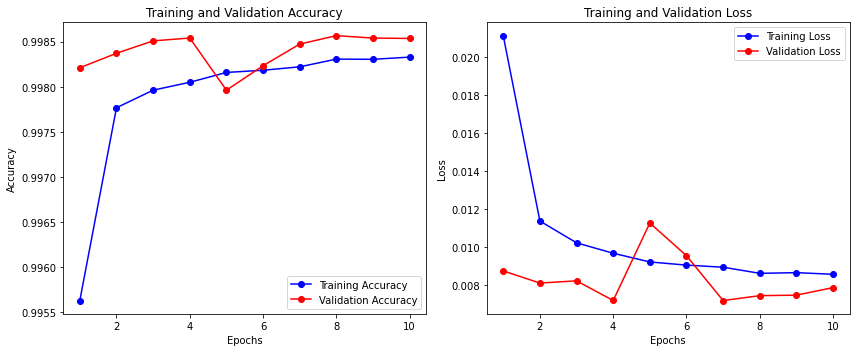

In [13]:
plot_training_history(dnn_history)

### Plot CNN Accuracy curve

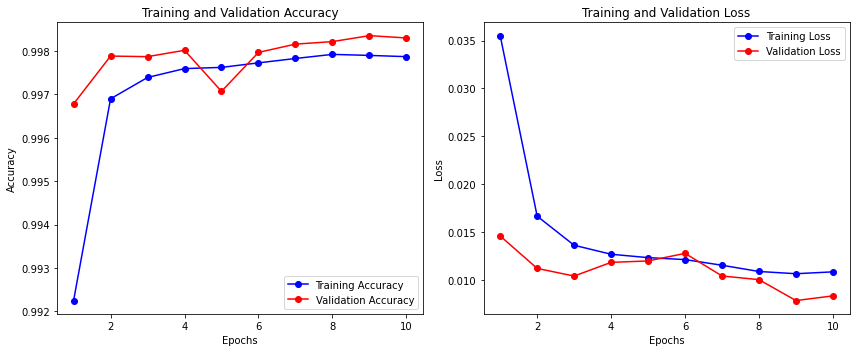

In [14]:
plot_training_history(cnn_history)

### Plot RNN Accuracy curve

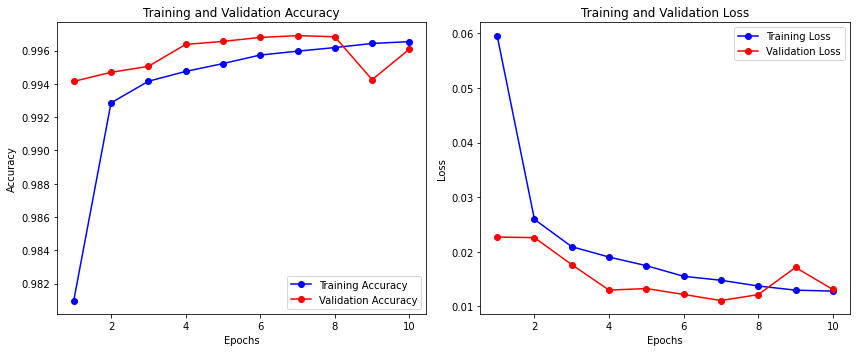

In [15]:
plot_training_history(rnn_history)

Save models checkpoint

In [16]:
dnn_model.save('./model_checkpoints/dnn_lane_lane_topology_model.keras')
cnn_model.save('./model_checkpoints/cnn_lane_lane_topology_model.keras')
rnn_model.save('./model_checkpoints/rnn_lane_lane_topology_model.keras')

### Evaluate model

#### Training Accuracy

### DNN model Accuracy

In [17]:
dnn_model = tf.keras.models.load_model('dnn_lane_lane_topology_model.keras')
loss, accuracy = dnn_model.evaluate(X_train, y_train)
print(f"Traing Accuracy: {accuracy * 100:.2f}%")

35181/35181 [==============================] - 26s 733us/step - loss: 0.0071 - accuracy: 0.9984
Traing Accuracy: 99.84%


### CNN model Accuracy

In [18]:
cnn_model = tf.keras.models.load_model('cnn_lane_lane_topology_model.keras')
loss, accuracy = cnn_model.evaluate(X_train, y_train)
print(f"Traing Accuracy: {accuracy * 100:.2f}%")

35181/35181 [==============================] - 62s 2ms/step - loss: 0.0156 - accuracy: 0.9965
Traing Accuracy: 99.65%


### RNN model Accuracy

In [19]:
rnn_model = tf.keras.models.load_model('rnn_lane_lane_topology_model.keras')
loss, accuracy = rnn_model.evaluate(X_train, y_train)
print(f"Traing Accuracy: {accuracy * 100:.2f}%")

35181/35181 [==============================] - 103s 3ms/step - loss: 0.0102 - accuracy: 0.9970
Traing Accuracy: 99.70%


### Validation Accuracy

In [20]:
X_val, y_val = prepare_partition_data(data_dict, 'val')
X_val, y_val = balance_dataset(X_val, y_val)

In [21]:
loss, dnn_accuracy = dnn_model.evaluate(X_val, y_val)
loss, cnn_accuracy = cnn_model.evaluate(X_val, y_val)
loss, rnn_accuracy = rnn_model.evaluate(X_val, y_val)


print(f"DNN Validattion Accuracy: {dnn_accuracy * 100:.2f}%")
print(f"CNN Validattion Accuracy: {cnn_accuracy * 100:.2f}%")
print(f"NNN Validattion Accuracy: {rnn_accuracy * 100:.2f}%")

7505/7505 [==============================] - 23s 3ms/step - loss: 0.0102 - accuracy: 0.9974
DNN Validattion Accuracy: 99.85%
CNN Validattion Accuracy: 99.63%
NNN Validattion Accuracy: 99.74%


### Model Performance

The final validation accuracy of approximately 99.85% indicates that the model is highly accurate in predicting the lane-lane topology on validation set. This suggests that the MLP architecture, along with the chosen hyperparameters, is effective for this specific task.

## Conclusion

The implemented neural network model successfully addresses the lane-lane topology prediction task with the following achievements:

- The model achieves high accuracy in predicting lane adjacency relationships, with validation accuracy reaching 99.84% after 10 epochs of training.

- The balanced dataset approach effectively handles the class imbalance problem by equalizing the number of positive and negative samples, ensuring unbiased training.

- The architecture consisting of 4 dense layers (128, 64, 32, 1 neurons) proves effective for learning the spatial relationships between lane endpoints.


## Key Performance Metrics

- **DNN Validation Accuracy:** 99.86%
- **CNN Validation Accuracy:** 99.64%
- **RNN Validation Accuracy:** 99.74%

**Comparing the performance of different model architectures:**

1. The Deep Neural Network (DNN) achieved the highest validation accuracy at 99.86%, demonstrating its effectiveness in capturing complex relationships between lanes.

2. The Recurrent Neural Network (RNN) performed slightly better than the Convolutional Neural Network (CNN), with validation accuracies of 99.74% and 99.64% respectively. This suggests that the sequential nature of RNNs may be beneficial for lane-lane topology detection.

3. All three models achieved exceptionally high accuracy, indicating that they are well-suited for the lane-lane topology detection task.

4. The small difference between training loss (0.00979) and validation loss (0.01087) suggests good generalization without significant overfitting.

## Future Improvements

The model could be enhanced through:

- Implementation of a Graph Neural Network (GNN) architecture to better capture the topological relationships
- Incorporation of additional lane features beyond endpoint coordinates
- Exploration of different data augmentation techniques to improve generalization
- Testing on a more diverse set of road scenarios and conditions

This implementation provides a strong foundation for lane-lane topology prediction in autonomous driving systems, demonstrating robust performance on the OpenLane-V2 dataset.